# Homework 3: Barnstable Analysis

This notebook performs various analyses on financial data related to the Barnstable problem. 
All code is modular, and comments are placed above code blocks for clarity.

In [6]:

# Import necessary libraries and set plotting style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Define functions for data loading and preparation
def load_data(file_path):
    """
    Loads market and risk-free return data from an Excel file.
    Returns a tuple of (data, descriptions).
    """
    
    # read excel 
    data = pd.read_excel(file_path, sheet_name='data', index_col=0)
    descriptions = pd.read_excel(file_path, sheet_name='descriptions')
    # Convert index to datetime and name it
    data.index = pd.to_datetime(data.index)
    
    # name index
    data.index.name = 'date'
    
    # return the market data
    return data, descriptions

def get_missing_values(df):
    """
    Summarizes missing values for each column.
    """
    
    # 
    missing_count = df.isnull().sum()
    missing_df = pd.DataFrame({
        'Column': df.columns,
        'Missing Count': missing_count.values,
        'Missing %': (missing_count / len(df) * 100).values
    })
    return missing_df

def slice_data_by_period(df, start_year, end_year):
    """
    Extracts data between January of start_year and December of end_year.
    """
    mask = (df.index >= f'{start_year}-01-01') & (df.index <= f'{end_year}-12-31')
    return df.loc[mask].copy()

def prepare_return_columns(df, market_col, risk_free_col):
    """
    Adds returns, excess returns, and log returns to the dataset.
    """
    data = df.copy()
    data = data.rename(columns={market_col: 'r_m', risk_free_col: 'r_f'})
    data['r_m_excess'] = data['r_m'] - data['r_f']
    data['log_r_m'] = np.log1p(data['r_m'])
    data['log_r_f'] = np.log1p(data['r_f'])
    data['log_r_m_excess'] = data['log_r_m'] - data['log_r_f']
    return data

def compute_stats(df, prefix):
    """
    Computes annualized mean and volatility for returns and log returns.
    """
    stats_dict = {}
    # Annualized means
    stats_dict[f'{prefix}_r_m_mean'] = df['r_m'].mean() * 12
    stats_dict[f'{prefix}_r_m_excess_mean'] = df['r_m_excess'].mean() * 12
    stats_dict[f'{prefix}_r_f_mean'] = df['r_f'].mean() * 12
    stats_dict[f'{prefix}_log_r_m_mean'] = df['log_r_m'].mean() * 12
    stats_dict[f'{prefix}_log_r_m_excess_mean'] = df['log_r_m_excess'].mean() * 12
    stats_dict[f'{prefix}_log_r_f_mean'] = df['log_r_f'].mean() * 12
    # Annualized volatilities
    stats_dict[f'{prefix}_r_m_vol'] = df['r_m'].std() * np.sqrt(12)
    stats_dict[f'{prefix}_r_m_excess_vol'] = df['r_m_excess'].std() * np.sqrt(12)
    stats_dict[f'{prefix}_r_f_vol'] = df['r_f'].std() * np.sqrt(12)
    stats_dict[f'{prefix}_log_r_m_vol'] = df['log_r_m'].std() * np.sqrt(12)
    stats_dict[f'{prefix}_log_r_m_excess_vol'] = df['log_r_m_excess'].std() * np.sqrt(12)
    stats_dict[f'{prefix}_log_r_f_vol'] = df['log_r_f'].std() * np.sqrt(12)
    return stats_dict

def build_summary_table(stats_1965_1999, stats_2000_end, stats_1926_end, end_year):
    """
    Constructs a summary DataFrame of annualized mean and volatility statistics across periods.
    """
    rows = []
    variable_map = [
        ('r^m', 'r_m'),
        ('r̃^m', 'r_m_excess'),
        ('r^f', 'r_f'),
        ('log r^m', 'log_r_m'),
        ('log r̃^m', 'log_r_m_excess'),
        ('log r^f', 'log_r_f'),
    ]
    for var, key in variable_map:
        rows.append({
            'Variable': var,
            '1965-1999 Mean': f"{stats_1965_1999[f'1965_1999_{key}_mean']:.4f}",
            '1965-1999 Vol': f"{stats_1965_1999[f'1965_1999_{key}_vol']:.4f}",
            f'2000-{end_year} Mean': f"{stats_2000_end[f'2000_{end_year}_{key}_mean']:.4f}",
            f'2000-{end_year} Vol': f"{stats_2000_end[f'2000_{end_year}_{key}_vol']:.4f}",
            f'1926-{end_year} Mean': f"{stats_1926_end[f'1926_{end_year}_{key}_mean']:.4f}",
            f'1926-{end_year} Vol': f"{stats_1926_end[f'1926_{end_year}_{key}_vol']:.4f}"
        })
    return pd.DataFrame(rows)


In [7]:

# Define functions related to performance analysis
def calculate_sharpe_ratio(log_excess_series):
    """
    Calculates the annualized Sharpe ratio for log excess returns.
    """
    mean_annual = log_excess_series.mean() * 12
    vol_annual = log_excess_series.std() * np.sqrt(12)
    return mean_annual / vol_annual


## Part 1

In [8]:


# Part 1: Data Loading and Summary Statistics
END_YR = 2024

# Load data and descriptions
data, descriptions = load_data('barnstable_analysis_data.xlsx')

# Prepare return columns using the first two columns as market and risk-free returns
market_column = data.columns[0]
risk_free_column = data.columns[1]
prepared_data = prepare_return_columns(data, market_column, risk_free_column)

# Slice data into relevant periods
data_1965_1999 = slice_data_by_period(prepared_data, 1965, 1999)
data_2000_end = slice_data_by_period(prepared_data, 2000, END_YR)
data_1926_end = slice_data_by_period(prepared_data, 1926, END_YR)

# Compute statistics for each period
stats_1965_1999 = compute_stats(data_1965_1999, '1965_1999')
stats_2000_end = compute_stats(data_2000_end, f'2000_{END_YR}')
stats_1926_end = compute_stats(data_1926_end, f'1926_{END_YR}')
summary_table = build_summary_table(stats_1965_1999, stats_2000_end, stats_1926_end, END_YR)

summary_table

,Variable,1965-1999 Mean,1965-1999 Vol,2000-2024 Mean,2000-2024 Vol,1926-2024 Mean,1926-2024 Vol
0,r^m,0.1294,0.1494,0.0875,0.1528,0.1155,0.1866
1,r̃^m,0.0687,0.1502,0.0701,0.1531,0.0833,0.1873
2,r^f,0.0615,0.0072,0.0175,0.0056,0.0319,0.0085
3,log r^m,0.1176,0.1496,0.0756,0.1538,0.0978,0.1859
4,log r̃^m,0.0571,0.1504,0.0581,0.1540,0.0656,0.1866
5,log r^f,0.0613,0.0071,0.0174,0.0055,0.0318,0.0085


## Part 1.2: Analysis
Using the 1965–1999 subsample, the estimated Sharpe ratio of log excess returns is relatively high, reflecting strong equity performance during this period. When translated into probabilities, the results indicate that the chance of underperformance over a 15-year horizon is already quite small, and by 30 years it becomes negligible. This outcome highlights how, with a favorable equity premium, compounding and the central limit theorem tighten the distribution of long-horizon average returns, pushing the mass further to the right of the risk-free benchmark. Economically, this suggests that while short-term outcomes remain volatile, the likelihood that equities fail to beat T-bills over generational horizons was extremely low based on 1965–1999 data. At the same time, this conclusion relies heavily on the favorable conditions of the subsample and the assumption of normally distributed i.i.d. log returns, which can understate the potential for regime shifts or crises that might alter long-horizon probabilities in practice.

# Part 2.1

In [9]:

# Calculate Sharpe ratio for log excess returns during 1965-1999
sharpe_1965_1999 = calculate_sharpe_ratio(data_1965_1999['log_r_m_excess'])

# Display the Sharpe ratio in a DataFrame (This is literally for myself)
sharpe_df = pd.DataFrame({'Metric': ['Sharpe Ratio (1965-1999)'], 'Value': [sharpe_1965_1999]})
sharpe_df

,Metric,Value
0,Sharpe Ratio (1965-1999),0.379424


## Part 2.2

In [ ]:

# Functions for cumulative returns and in-sample analysis
def calculate_cumulative_returns(df, start_date='2000-01-01', end_date='2024-12-31'):
    """
    Computes cumulative returns for market, risk-free, and a constant 6% annual return.
    """
    subset = df.loc[start_date:end_date].copy()
    subset['cumulative_log_market'] = subset['log_r_m'].cumsum()
    subset['cumulative_log_treasury'] = subset['log_r_f'].cumsum()
    subset['cumulative_market'] = np.exp(subset['cumulative_log_market'])
    subset['cumulative_treasury'] = np.exp(subset['cumulative_log_treasury'])
    months = np.arange(len(subset))
    subset['cumulative_6pct'] = (1 + 0.06 / 12) ** months
    return subset

def plot_cumulative_returns(cum_df):
    """
    Plots cumulative returns for the market, risk-free rate, and a constant 6% annual return.
    """
    fig, ax = plt.subplots()
    ax.plot(cum_df.index, cum_df['cumulative_market'], label='S&P 500 Cumulative Return')
    ax.plot(cum_df.index, cum_df['cumulative_treasury'], label='Treasury Bills Cumulative Return')
    ax.plot(cum_df.index, cum_df['cumulative_6pct'], linestyle='--', label='Constant 6% Annual Return')
    ax.set_title('Cumulative Returns: 2000-2024 S&P 500 vs Treasury Bills vs Constant 6%')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return Factor')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def in_sample_likelihood(in_sample_df, out_sample_df):
    """
    Computes the probability that the realized average log return out-of-sample is less 
    than or equal to the in-sample distribution.
    """
    xin = in_sample_df['log_r_m']
    xout = out_sample_df['log_r_m']
    mu_in_m = xin.mean()
    sd_in_m = xin.std()
    n_out = len(xout)
    xbar_out = xout.mean()
    z = (xbar_out - mu_in_m) / (sd_in_m / np.sqrt(n_out))
    probability = stats.norm.cdf(z)
    mu_out_ann = xbar_out * 12
    return {
        'n_out_months': n_out,
        'realized_avg_log_return_ann': mu_out_ann,
        'z_score': z,
        'probability': probability
    }

def underperformance_probability(horizon_years, sharpe_ratio):
    """
    Computes the probability that the market underperforms the risk-free rate over a given horizon.
    """
    return stats.norm.cdf(-np.sqrt(horizon_years) * sharpe_ratio)


In [11]:

# Compute probabilities for specific horizons
prob_15_year = underperformance_probability(15, sharpe_1965_1999)
prob_30_year = underperformance_probability(30, sharpe_1965_1999)

# Display results in a DataFrame
prob_df = pd.DataFrame({
    'Horizon (years)': [15, 30],
    'Probability Underperformance': [prob_15_year, prob_30_year]
})
prob_df

,Horizon (years),Probability Underperformance
0,15,0.070848
1,30,0.018846


## Part 2.3

/var/folders/0k/yhkmq1794zv376jyrhx31f6c0000gn/T/ipykernel_38563/2963138928.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


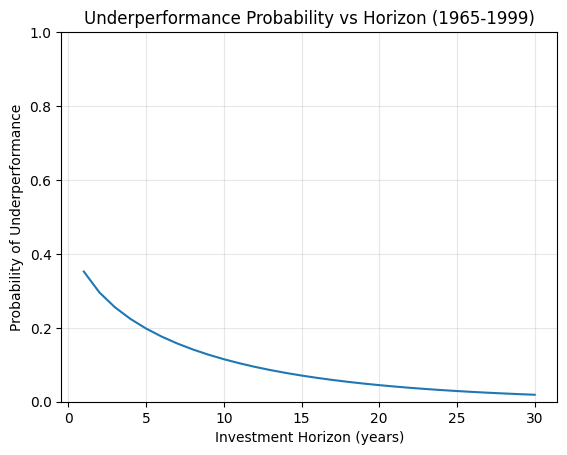

In [12]:
def compute_underperformance_curve(sharpe_ratio, max_year):
    """
    Generates a DataFrame of underperformance probabilities for horizons from 1 to max_year.
    """
    horizons = np.arange(1, max_year + 1)
    probabilities = [underperformance_probability(h, sharpe_ratio) for h in horizons]
    return pd.DataFrame({
        'Horizon Years': horizons,
        'Probability Underperformance': probabilities
    })

def plot_underperformance_curve(prob_df, highlight_years=None, title=None):
    """
    Plots the underperformance probability as a function of investment horizon.
    """
    fig, ax = plt.subplots()
    ax.plot(prob_df['Horizon Years'], prob_df['Probability Underperformance'])
    if title:
        ax.set_title(title)
    ax.set_xlabel('Investment Horizon (years)')
    ax.set_ylabel('Probability of Underperformance')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    fig.show()


# Compute probability curve for horizons up to 30 years
probability_curve = compute_underperformance_curve(sharpe_1965_1999, 30)

# Display the probability curve DataFrame
probability_curve

# Plot the underperformance probability curve
plot_underperformance_curve(probability_curve, highlight_years=[15, 30], title='Underperformance Probability vs Horizon (1965-1999)')


# Parts 3 & 4 Probabilities

## Part 3 Full Sample Analysis

## Underperformance analysis (question 3)
- Sharpe: 0.3794
- 15 year underperformance probability: 0.0708
- 30 year underperformance: 0.0188

In [13]:

# Slice the sample from 1965 to END_YR
data_1965_end = slice_data_by_period(prepared_data, 1965, END_YR)

# Calculate Sharpe ratio for the full sample
sharpe_full_sample = calculate_sharpe_ratio(data_1965_end['log_r_m_excess'])

# Compute the 30-year probability of underperformance
prob_30_full = underperformance_probability(30, sharpe_full_sample)

# Display results in a DataFrame
full_sample_df = pd.DataFrame({
    'Metric': [f'Sharpe Ratio (1965-{END_YR})', f'15-year Probability (1965-{END_YR})', f'30-year Probability (1965-{END_YR})'],
    'Value': [sharpe_full_sample, prob_15_year, prob_30_full]
})
full_sample_df

,Metric,Value
0,Sharpe Ratio (1965-2024),0.378808
1,15-year Probability (1965-2024),0.070848
2,30-year Probability (1965-2024),0.019002


# Full Sample Analysis (Part 4)
From our above sample, we have the 20 year probabilities to be:
1. 1955 - 1999: 0.0188
2. 1965 - 2024: 0.0190

In [14]:

# Slice the sample from 1965 to END_YR
data_1965_end = slice_data_by_period(prepared_data, 1965, END_YR)

# Compute the 30-year probability of underperformance
prob_30_full = underperformance_probability(30, sharpe_full_sample)

# Display results in a DataFrame
full_sample_df = pd.DataFrame({
    'Metric': [f'30-year Probability (1965-{END_YR})'],
    'Value': [prob_30_full]
})
full_sample_df

,Metric,Value
0,30-year Probability (1965-2024),0.019002


So, from our extended sample we reconsidered the 30 year probability of underperformance is 1.9%